# Advanced Wind Turbine Simulation Workflow

* A more advanced turbine workflow will include many steps (Which have been showcased in previous examples)
* The process exemplified here includes:
  1. Weather data extraction from a MERRA dataset (windspeed, pressure, temperature)
  2. Spatial adjustment of the windspeeds
  3. Vertical projection of the wind speeds
  4. Wind speed density correction
  5. Power curve convolution
  6. Capacity Factor Estimation

In [24]:
import reskit as rk
from reskit import windpower

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Simulate a Single Location

In [25]:
# Set some constants for later

TURBINE_CAPACITY = 4200 # kW
TURBINE_HUB_HEIGHT = 120 # meters
TURBINE_ROTOR_DIAMETER = 136 # meters
TURBINE_LOCATION = (6.0,50.5) # (lon, lat)

In [26]:
# 1. Create a weather source, load, and extract weather variables
src = rk.weather.sources.MerraSource(rk._TEST_DATA_["weather_data"], bounds=[5,49,7,52], verbose=False)

src.loadWindSpeed()
src.loadPressure()
src.loadTemperature()

raw_windspeeds = src.get("windspeed", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_pressure = src.get("pressure", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_temperature = src.get("air_temp", locations=TURBINE_LOCATION, interpolation='bilinear')

print(raw_windspeeds.head())

2015-01-01 00:30:00.000013+00:00    5.383743
2015-01-01 01:30:00+00:00           5.323299
2015-01-01 02:30:00.000026+00:00    5.232418
2015-01-01 03:30:00.000013+00:00    5.160997
2015-01-01 04:30:00+00:00           5.439261
Name: (6.00000,50.50000), dtype: float64


In [27]:
# 2. Adjust wind speeds to turbine location

spatially_adjusted_windspeeds = rk.weather.windutil.adjustLraToGwa(windspeed=raw_windspeeds, 
                                                                   targetLoc=TURBINE_LOCATION,
                                                                   gwa=rk._TEST_DATA_['gwa50-like.tif'], 
                                                                   longRunAverage=src.LONG_RUN_AVERAGE_50M_SOURCE,
                                                                   interpolation='bilinear')

spatially_adjusted_windspeeds.head()

2015-01-01 00:30:00.000013+00:00    3.691850
2015-01-01 01:30:00+00:00           3.650401
2015-01-01 02:30:00.000026+00:00    3.588080
2015-01-01 03:30:00.000013+00:00    3.539104
2015-01-01 04:30:00+00:00           3.729921
Name: (6.00000,50.50000), dtype: float64

In [28]:
# 3. Vertically project wind speeds to hub height

roughness = rk.weather.windutil.roughnessFromCLC(clcPath=rk._TEST_DATA_['clc-aachen_clipped.tif'],
                                                 loc=TURBINE_LOCATION)


projected_windspeed = rk.weather.windutil.projectByLogLaw(measuredWindspeed=spatially_adjusted_windspeeds,
                                                          measuredHeight=50, # The MERRA dataset offers windspeeds at 50m
                                                          targetHeight=TURBINE_HUB_HEIGHT,
                                                          roughness=roughness)

print(projected_windspeed.head())

2015-01-01 00:30:00.000013+00:00    4.461451
2015-01-01 01:30:00+00:00           4.411362
2015-01-01 02:30:00.000026+00:00    4.336050
2015-01-01 03:30:00.000013+00:00    4.276864
2015-01-01 04:30:00+00:00           4.507459
Name: (6.00000,50.50000), dtype: float64


In [29]:
# 4. Apply density correction

pressure_corrected_windspeeds = rk.weather.windutil.densityAdjustment(windspeed=projected_windspeed,
                                                                      pressure=raw_pressure,
                                                                      temperature=raw_temperature,
                                                                      height=TURBINE_HUB_HEIGHT)

pressure_corrected_windspeeds.head()

2015-01-01 00:30:00.000013+00:00    4.498938
2015-01-01 01:30:00+00:00           4.447499
2015-01-01 02:30:00.000026+00:00    4.370992
2015-01-01 03:30:00.000013+00:00    4.311491
2015-01-01 04:30:00+00:00           4.544032
Name: (6.00000,50.50000), dtype: float64

In [30]:
# 5 Power curve estimation and convolution

power_curve = windpower.SyntheticPowerCurve(capacity=TURBINE_CAPACITY, rotordiam=TURBINE_ROTOR_DIAMETER)

convoluted_power_curve = windpower.convolutePowerCurveByGuassian(powerCurve=power_curve, stdScaling=0.06, stdBase=0.1)

In [31]:
# 6 Capacity factor estimation
capacity_factors = windpower.simulateTurbine(windspeed=pressure_corrected_windspeeds,
                                             powerCurve=convoluted_power_curve)

capacity_factors.head()

2015-01-01 00:30:00.000013+00:00    0.071262
2015-01-01 01:30:00+00:00           0.068269
2015-01-01 02:30:00.000026+00:00    0.063929
2015-01-01 03:30:00.000013+00:00    0.060645
2015-01-01 04:30:00+00:00           0.073936
dtype: float64

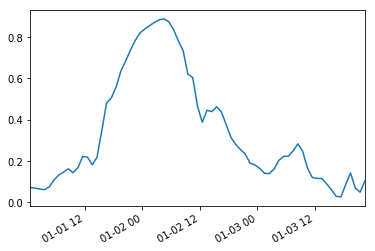

In [32]:
capacity_factors.plot()
plt.show()

# Simulate multiple locations at once (recommended)

In [33]:
TURBINE_CAPACITY = 4200 # kW
TURBINE_HUB_HEIGHT = 120 # meters
TURBINE_ROTOR_DIAMETER = 136 # meters
TURBINE_LOCATION = [(6.25,51.), (6.50,51.), (6.25,50.75)] # (lon,lat)


# 1
raw_windspeeds = src.get("windspeed", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_pressure = src.get("pressure", locations=TURBINE_LOCATION, interpolation='bilinear')
raw_temperature = src.get("air_temp", locations=TURBINE_LOCATION, interpolation='bilinear')

#2 
spatially_adjusted_windspeeds = rk.weather.windutil.adjustLraToGwa(windspeed=raw_windspeeds, 
                                                                   targetLoc=TURBINE_LOCATION,
                                                                   gwa=rk._TEST_DATA_['gwa50-like.tif'], 
                                                                   longRunAverage=src.LONG_RUN_AVERAGE_50M_SOURCE,
                                                                   interpolation='bilinear')

# 3
roughness = rk.weather.windutil.roughnessFromCLC(clcPath=rk._TEST_DATA_['clc-aachen_clipped.tif'],
                                                 loc=TURBINE_LOCATION)

projected_windspeed = rk.weather.windutil.projectByLogLaw(measuredWindspeed=spatially_adjusted_windspeeds,
                                                          measuredHeight=50, # The MERRA dataset offers windspeeds at 50m
                                                          targetHeight=TURBINE_HUB_HEIGHT,
                                                          roughness=np.array(roughness))

# 4
pressure_corrected_windspeeds = rk.weather.windutil.densityAdjustment(windspeed=projected_windspeed,
                                                                      pressure=raw_pressure,
                                                                      temperature=raw_temperature,
                                                                      height=TURBINE_HUB_HEIGHT)

# 5
power_curve = windpower.SyntheticPowerCurve(capacity=TURBINE_CAPACITY, rotordiam=TURBINE_ROTOR_DIAMETER)
convoluted_power_curve = windpower.convolutePowerCurveByGuassian(powerCurve=power_curve, stdScaling=0.06, stdBase=0.1)

# 6
capacity_factors = windpower.simulateTurbine(windspeed=pressure_corrected_windspeeds,
                                             powerCurve=convoluted_power_curve)


# Print result
capacity_factors.head()

,"(6.25000,51.00000)","(6.50000,51.00000)","(6.25000,50.75000)"
2015-01-01 00:30:00.000013+00:00,0.177383,0.127191,0.043987
2015-01-01 01:30:00+00:00,0.180171,0.127224,0.042301
2015-01-01 02:30:00.000026+00:00,0.175838,0.125234,0.039020
2015-01-01 03:30:00.000013+00:00,0.158180,0.114935,0.034260
2015-01-01 04:30:00+00:00,0.165764,0.123624,0.038762


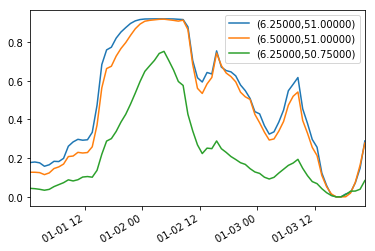

In [34]:
capacity_factors.plot()
plt.show()